## Байесовская линейная регрессия с библиотекой PYMC3 

В этой практике рассмотрим PYMC3 для байесовской линейной регрессии с оценкой апостериорных распределений вероятностей. 

In [1]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Давайте создадим некоторые переменные для нашей регрессии. Наши истинные значния:
* $\alpha = 1$
* $\sigma = 1$
* $\beta = 2.5$

Наша итоговая переменная будет расчитана по:
$$ Y = \alpha + \beta_1 X + N(0,\sigma).$$

In [45]:
# фиксируем сид
np.random.seed(42)

# Задаем значения параметров
alpha, sigma = 1, 1
beta = [2.5]

# Размер датасета
size = 1000

# Генерируем вектора признаков
X = np.random.randn(size)

# Считаем
Y = alpha + beta * X + np.random.randn(size)*sigma

отрисовка

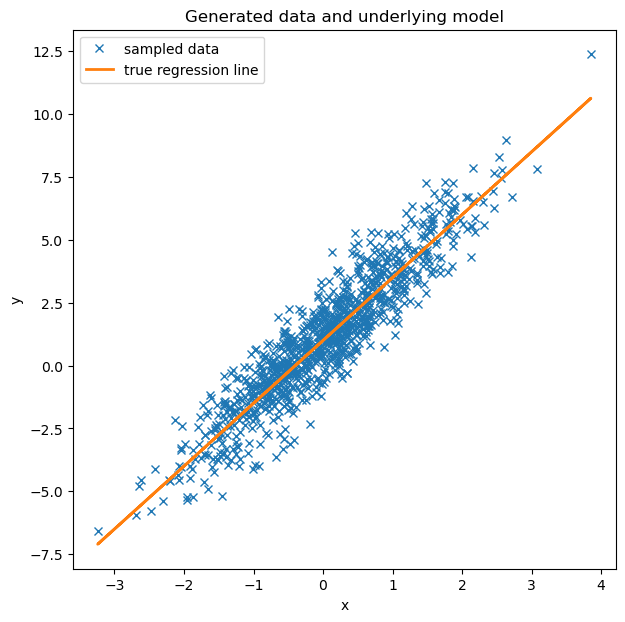

In [26]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel="x", ylabel="y", title="Generated data and underlying model")
ax.plot(X, Y, "x", label="sampled data")
ax.plot(X, alpha + beta * X, label="true regression line", lw=2.0)
plt.legend(loc=0);

Теперь построим модель.

Априорные распределения:
* $\alpha \sim \mathcal{N}(\mu=0,\sigma=10)$
* $\beta[i] \sim \mathcal{N}(\mu=0,\sigma=10)$, where $i=1$
* $\sigma \sim \textrm{half-normal}(\sigma=1)$

Определим ожидаемое значение:
\begin{equation}
  \text{Y} = \alpha + \beta*X
\end{equation}

Байесовцы придерживаются вероятностного взгляда на мир и выражают эту модель в терминах вероятностных распределений. Нашу приведенную выше линейную регрессию можно переписать, чтобы получить:

\begin{equation}
  \text{Y}\sim \mathcal{N}(\mu=\mu,\sigma=\sigma).
\end{equation}

In [27]:
basic_model = pm.Model()

with basic_model:

    # Приоры для неизвестных параметров модели 
    alpha1 = pm.Normal('alpha', mu=0, sigma=100) #intercept
    beta1 = pm.Normal('beta', mu=0, sigma=100) #slope
    sigma1 = pm.HalfNormal('sigma', sigma=100)

    # Ожидаемое значение переменной
    mu = alpha1 + beta1 * X

    # Вероятность (выборочное распределение) наблюдений / Likelihood (sampling distribution) of observations
    likelihood = pm.Normal('likelihood', mu=mu, sigma=sigma1, observed=Y)

    # Получаем 5000 объектов из апостериорного распределения
    linear_trace = pm.sample(5000)

The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.
c:\Users\anzel\anaconda3\envs\envpymc\lib\site-packages\deprecat\classic.py:232: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 59 seconds.


In [28]:
basic_model

C:\Users\anzel\AppData\Local\Temp\ipykernel_12704\2162765234.py:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(linear_trace, figsize = (12, 12))
c:\Users\anzel\anaconda3\envs\envpymc\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

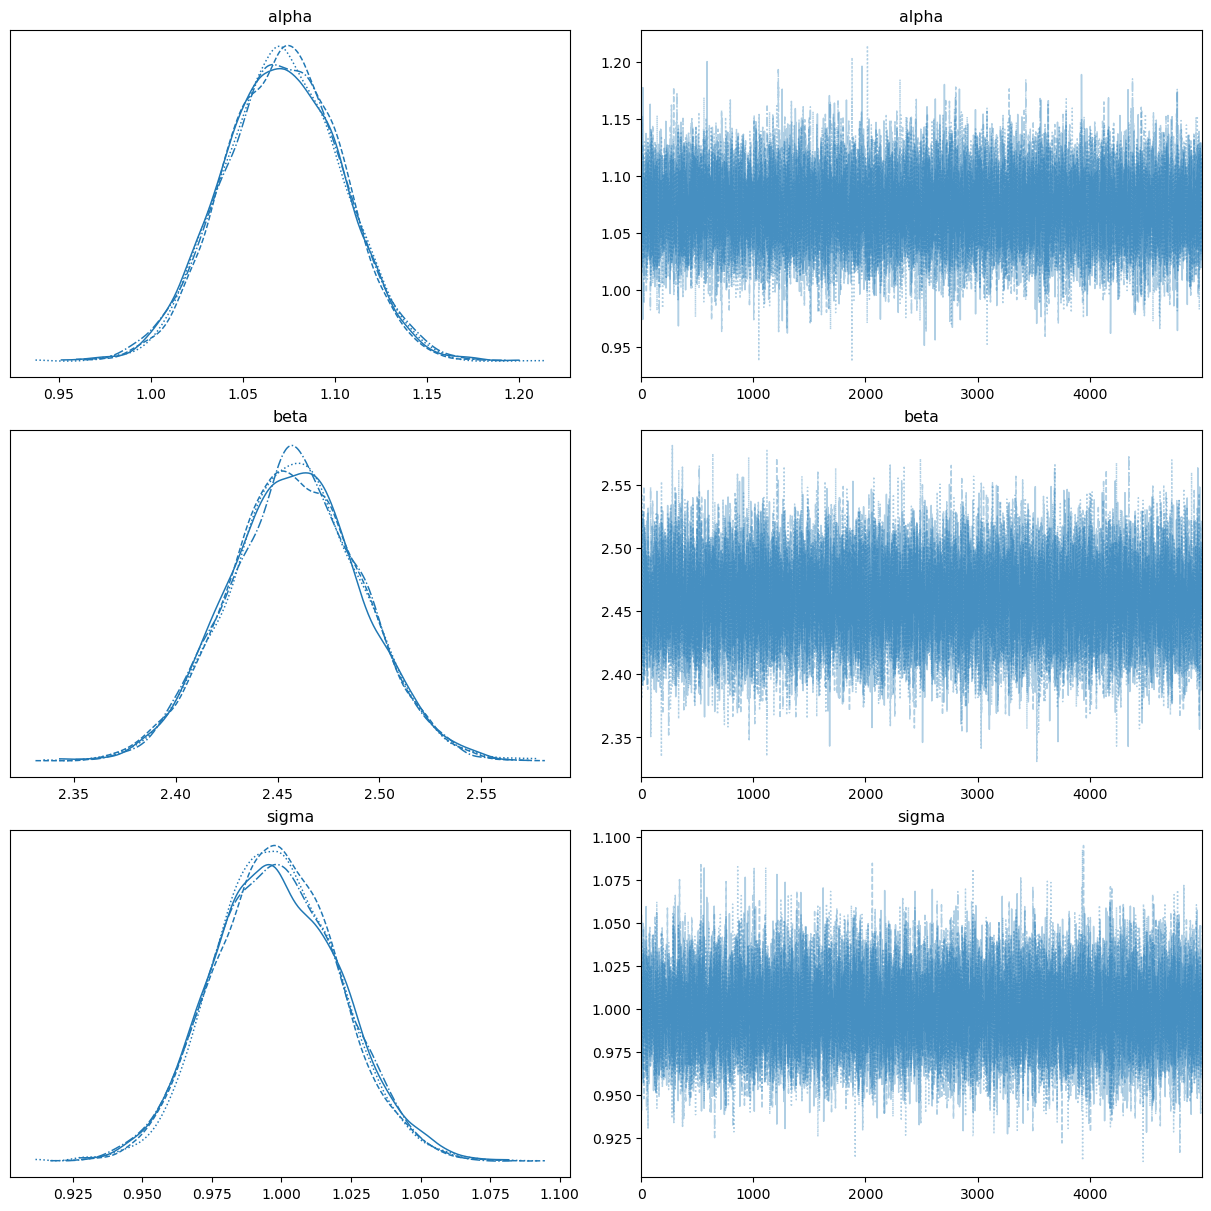

In [29]:
pm.traceplot(linear_trace, figsize = (12, 12))

traceplot - это стандартный хороший способ просмотра апостериорных распределений вероятностей

c:\Users\anzel\anaconda3\envs\envpymc\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


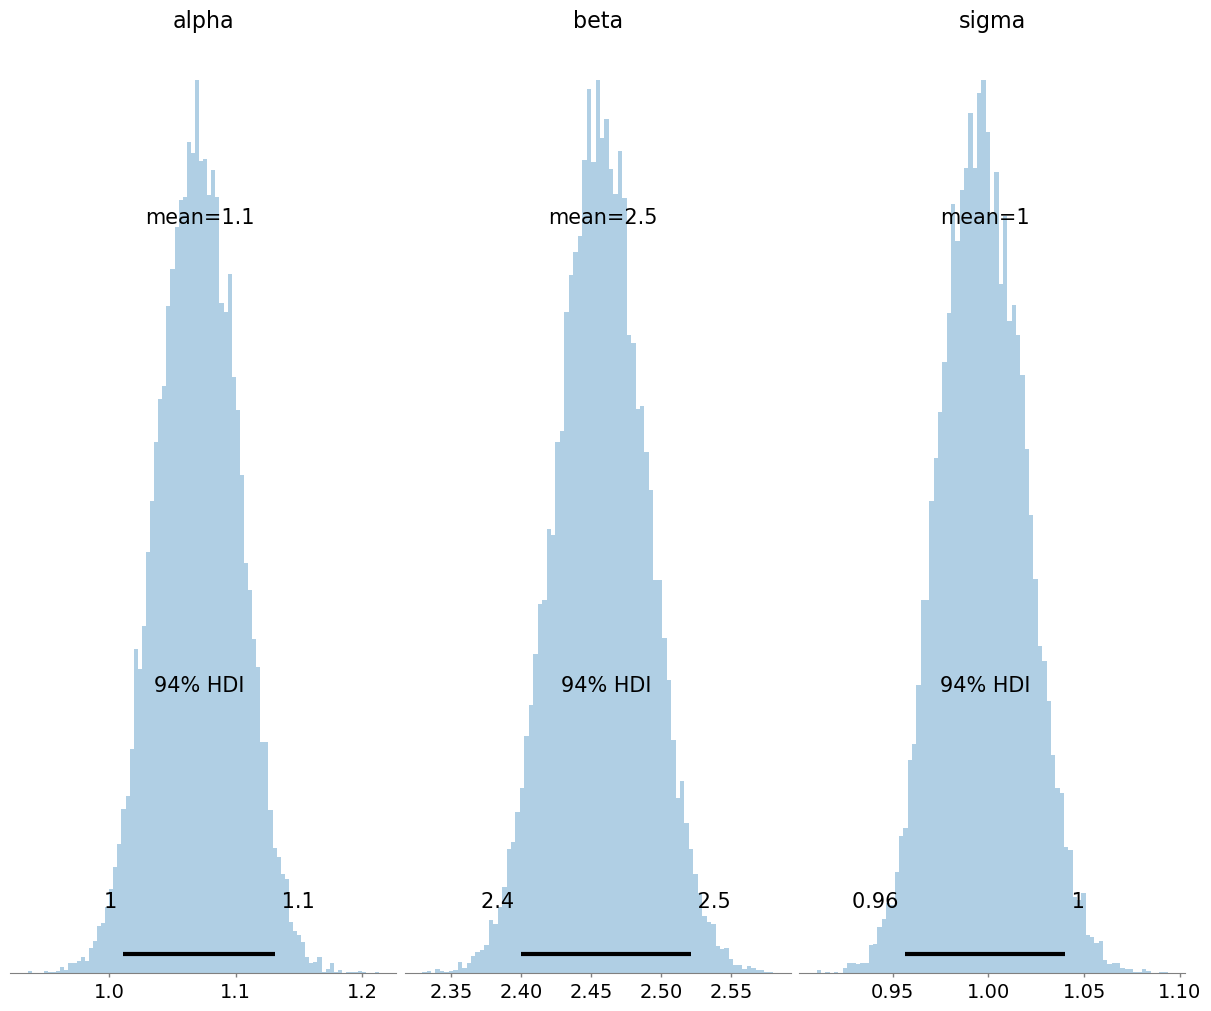

In [30]:
pm.plot_posterior(linear_trace, figsize = (12, 10), kind="hist");

Также есть встроенная функция сводки.

In [31]:
pm.summary(linear_trace).round(2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,1.07,0.03,1.01,1.13,0.0,0.0,26085.0,13665.0,1.0
beta,2.46,0.03,2.40,2.52,0.0,0.0,26039.0,13990.0,1.0
sigma,1.00,0.02,0.96,1.04,0.0,0.0,26682.0,15420.0,1.0


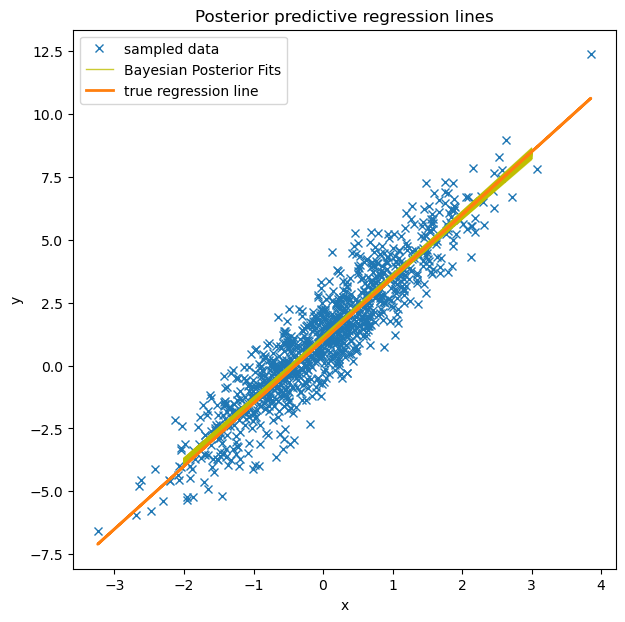

In [53]:
plt.figure(figsize=(7, 7))
plt.plot(X, Y, "x", label="sampled data")
pm.plot_posterior_predictive_glm(linear_trace, samples = 100, eval=np.linspace(-2, 3, 50), linewidth = 1, 
                                 color = 'y', alpha = 0.8, label = 'Bayesian Posterior Fits',
                                lm = lambda x, sample: sample['alpha'] + sample['beta'] * x);

plt.plot(X, alpha + beta * X, label="true regression line", lw=2.0)
plt.title("Posterior predictive regression lines")
plt.legend(loc=0)
plt.xlabel("x")
plt.ylabel("y");

In [49]:
alpha_mean = linear_trace['alpha'].mean() 
beta_mean = linear_trace['beta'].mean()

***

In [2]:
# фиксируем сид
np.random.seed(42)

# Задаем значения параметров
alpha, sigma = 1, 1
beta = [2.5]

# Размер датасета
size = 1000

# Генерируем вектора признаков
X = np.random.randn(size)

# Считаем
Y2 = [1 if x > 1 else 0 for x in alpha + beta * X + np.random.randn(size)*sigma]

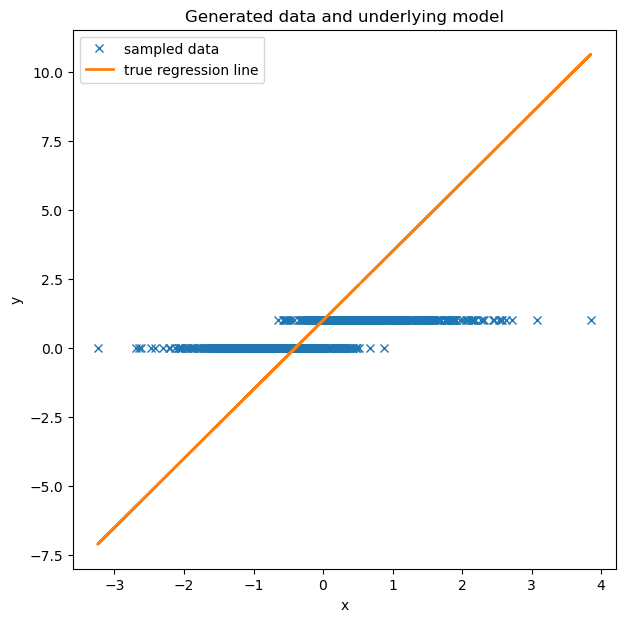

In [3]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel="x", ylabel="y", title="Generated data and underlying model")
ax.plot(X, Y2, "x", label="sampled data")
ax.plot(X, alpha + beta * X, label="true regression line", lw=2.0)
plt.legend(loc=0);

In [6]:
basic_model2 = pm.Model()

with basic_model2:

    # Приоры для неизвестных параметров модели 
    alpha2 = pm.Normal('alpha', mu=0, sigma=100) #intercept
    beta2 = pm.Normal('beta', mu=0, sigma=100) #slope
    sigma2 = pm.HalfNormal('sigma', sigma=100)

    # Ожидаемое значение переменной
    mu2 = pm.math.sigmoid(alpha2 + beta2 * X + sigma2)

    # Вероятность (выборочное распределение) наблюдений / Likelihood (sampling distribution) of observations
    likelihood2 = pm.Bernoulli('likelihood', mu2, observed=Y2)

    # Получаем 5000 объектов из апостериорного распределения
    linear_trace2 = pm.sample(500)

C:\Users\anzel\AppData\Local\Temp\ipykernel_22080\1029560125.py:17: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  linear_trace2 = pm.sample(500)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 70 seconds.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 76 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5957030232418615, but should be close to 0.8. Try to increase the number of tuning steps.
There were 94 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5382297329630462, but should be close to 0.8. Try to increase the number of tuning steps.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


In [26]:
linear_trace2[120]

{'alpha': -1.9903777373928457,
 'beta': 5.1878689691549305,
 'sigma_log__': 0.7966370685043819,
 'sigma': 2.2180691573781695}

In [20]:
sample

NameError: name 'sample' is not defined

c:\Users\anzel\anaconda3\envs\envpymc\lib\site-packages\pymc3\plots\posteriorplot.py:59: DeprecationWarning: The `plot_posterior_predictive_glm` function will migrate to Arviz in a future release. 
Keep up to date with `ArviZ <https://arviz-devs.github.io/arviz/>`_ for future updates.
  warnings.warn(


TypeError: object of type 'TensorVariable' has no len()

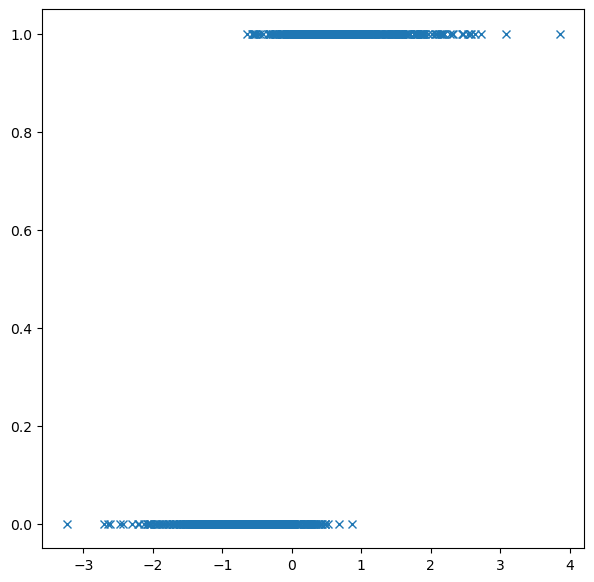

In [28]:
plt.figure(figsize=(7, 7))
plt.plot(X, Y2, "x", label="sampled data")
pm.plot_posterior_predictive_glm(linear_trace2, samples = 100, eval=np.linspace(-2, 3, 50), linewidth = 1, 
                                 color = 'y', alpha = 0.8, label = 'Bayesian Posterior Fits',
                                lm = lambda x, s: pm.math.sigmoid(s['alpha'] + s['beta'] * x));

plt.plot(X, alpha2 + beta2 * X, label="true regression line", lw=2.0)
plt.title("Posterior predictive regression lines")
plt.legend(loc=0)
plt.xlabel("x")
plt.ylabel("y");